In [7]:
import os, json, re, getpass
from dotenv import load_dotenv

load_dotenv(override=True)

True

In [8]:
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

In [9]:
_set_env("OPENAI_API_KEY")
_set_env("TAVILY_API_KEY")

#Check for LangSmith tracing
_set_env("LANGSMITH_TRACING")
_set_env("LANGSMITH_API_KEY")

os.environ["LANGCHAIN_PROJECT"] = "agents-testing"

In [10]:
#LangChain libraries
from langchain.chat_models import init_chat_model

from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.prompts import ChatPromptTemplate
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_tavily import TavilySearch
from langchain.schema import Document

#Other libraries
import numpy as np
from typing import Literal, List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [11]:
model_name_generate = "gpt-4o-mini"
llm_generate = init_chat_model(model_name_generate, model_provider="openai") 

In [12]:
web_search_tool = TavilySearch(max_results=10)

In [13]:
from youtube_search import YoutubeSearch

results = YoutubeSearch("smart fan in india", max_results=5).to_json()
print(results)


{"videos": [{"id": "rX7lkKdowbU", "thumbnails": ["https://i.ytimg.com/vi/rX7lkKdowbU/hq720.jpg?sqp=-oaymwEjCOgCEMoBSFryq4qpAxUIARUAAAAAGAElAADIQj0AgKJDeAE=&rs=AOn4CLDZTy8ki07XOb_tPXca9AQW4grRyQ", "https://i.ytimg.com/vi/rX7lkKdowbU/hq720.jpg?sqp=-oaymwEXCNAFEJQDSFryq4qpAwkIARUAAIhCGAE=&rs=AOn4CLAdUet1NyPOYSqrTXW36Z-1IhieEQ"], "title": "\ud83c\udf00 Best BLDC Ceiling Fan in India 2024 | Atomberg vs Havells vs Crompton vs Orient - Top Picks!", "long_desc": null, "channel": "Brand Investigation", "duration": "8:53", "views": "271,176 views", "publish_time": "1 year ago", "url_suffix": "/watch?v=rX7lkKdowbU&pp=ygUSc21hcnQgZmFuIGluIGluZGlh0gcJCa0JAYcqIYzv"}, {"id": "MiTyuJcpXq4", "thumbnails": ["https://i.ytimg.com/vi/MiTyuJcpXq4/hq720.jpg?sqp=-oaymwEjCOgCEMoBSFryq4qpAxUIARUAAAAAGAElAADIQj0AgKJDeAE=&rs=AOn4CLDhVgLqxtmsgi0sexrjwQT4vjk_lg", "https://i.ytimg.com/vi/MiTyuJcpXq4/hq720.jpg?sqp=-oaymwEXCNAFEJQDSFryq4qpAwkIARUAAIhCGAE=&rs=AOn4CLA57zuOzKLdhs_orDCVTObwZP1OAw"], "title": "Crompton Ene

In [14]:
from youtube_transcript_api import YouTubeTranscriptApi
from langchain.tools import tool

@tool
def get_transcript(video_url: str) -> str:
    """
    Fetches the English transcript of a YouTube video using the updated API (fetch()).
    Returns a plain text string with all transcript segments concatenated.
    """
    try:
        # Extract video ID (§ supports both URL formats)
        if "v=" in video_url:
            video_id = video_url.split("v=")[-1].split("&")[0]
        elif "youtu.be/" in video_url:
            video_id = video_url.split("youtu.be/")[-1]
        else:
            return "Invalid YouTube URL format."

        ytt_api = YouTubeTranscriptApi()
        transcript = ytt_api.fetch(video_id)  # Correct up-to-date method
        # Combine transcript text
        full_text = " ".join([snippet.text for snippet in transcript])
        return full_text

    except Exception as e:
        return f"Error getting transcript: {e}"


In [15]:
get_transcript.run("https://www.youtube.com/shorts/SwRKYEhK8dI")


'Invalid YouTube URL format.'

In [16]:
from itertools import islice
from youtube_comment_downloader import YoutubeCommentDownloader, SORT_BY_POPULAR
from langchain.tools import tool

@tool
def get_comments(video_url: str) -> str:
    """
    Fetches the top 50 popular comments from a YouTube video.
    Returns them as a newline-separated string.
    """
    try:
        # Extract video ID
        if "v=" in video_url:
            video_id = video_url.split("v=")[-1].split("&")[0]
        elif "youtu.be/" in video_url:
            video_id = video_url.split("youtu.be/")[-1]
        else:
            return "Invalid YouTube URL format."

        downloader = YoutubeCommentDownloader()
        comments_iter = downloader.get_comments_from_url(
            f"https://www.youtube.com/watch?v={video_id}",
            sort_by=SORT_BY_POPULAR
        )

        # Get first 50 comments
        texts = [c.get('text', '').strip() for c in islice(comments_iter, 50) if c.get('text')]
        if not texts:
            return "No comments found."

        return "\n\n".join(texts)

    except Exception as e:
        return f"Error fetching comments: {e}"


In [17]:
get_comments.run("https://www.youtube.com/watch?v=rX7lkKdowbU&pp=ygUSc21hcnQgZmFuIGluIGluZGlh")

'Check to Buy in Amazon India✅\r\n\r\n✅𝐀𝐭𝐨𝐦𝐛𝐞𝐫𝐠 Renesa 1200mm BLDC Motor 5 Star Rated Sleek Ceiling Fans with Remote :\r\nhttps://amzn.to/3wHmYov\r\n\r\n✅𝐇𝐚𝐯𝐞𝐥𝐥𝐬 Ambrose Decorative BLDC 1200mm Energy Saving with Remote Control :\r\nhttps://amzn.to/3OW8l7h\r\n\r\n✅𝐂𝐫𝐨𝐦𝐩𝐭𝐨𝐧 Energion Cromair 1200mm High Speed 5S 28W BLDC Ceiling Fan with Remote :\r\nhttps://amzn.to/48A9XdZ\r\n\r\n✅𝐎𝐫𝐢𝐞𝐧𝐭 Electric 1200 mm I Tome Remote | BLDC ceiling fan :\r\nhttps://amzn.to/48vArNv\n\ndon\'t buy fans from Flipkart . There replacement policy is very messy and they will not replace at any cost. I bought 8 fans and my 2 fans were defective and Flipkart refuses to replace my order\n\nThe mentioned KW is power consumption not the power......less KW means less power consumption and more savings on your electricity bill\n\nAtomberg is making noise. After frequent service , the noise is same. I think conventional fan are cheaper & good air supply.\n\nLast month I went Sowcarpet, Chennai to buy 3 BLDC fans. I aske

In [18]:
class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        google_search: gooogle search Data
        twitter_search: Twitter search Data
        youtube_search: Youtube search Data
    """

    question: str
    google_search: str
    twitter_search: str
    youtube_search: str
    sov_analysis: str
    generate: str
    

In [19]:
youtube_search(str)

NameError: name 'youtube_search' is not defined

In [ ]:

def youtube_search(state):
    """
    Retrieve youtube

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains youtube info
    """
    print("---retrieve_youtube---")
    question = state["question"]

    results = json.loads(YoutubeSearch(question, max_results=3).to_json())
    #print(results)

    video_summaries = []

    for video in results["videos"]:
        title = video.get("title")
        channel = video.get("channel")
        duration = video.get("duration")
        views = video.get("views")
        publish_time = video.get("publish_time")
        url_suffix = video.get("url_suffix")

        full_url = f"https://www.youtube.com{url_suffix}"

        summary = f"""
                Title       : {title}
                Channel     : {channel}
                Duration    : {duration}
                Views       : {views}
                Published   : {publish_time}
                Transcript  : {get_transcript.run(full_url)}
                Comments    : {get_comments.run(full_url)}
                {'-' * 80}
                """
        video_summaries.append(summary.strip())

    # Join all video summaries into a single string
    all_summaries_str = "\n\n".join(video_summaries)


    return {"youtube_search": all_summaries_str}

In [ ]:
def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---WEB SEARCH---")
    question = state["question"]

    # Web search
    searched_docs = web_search_tool.invoke({"query": question})
    # print(searched_docs) ## for debugging only
    # web_results = "\n".join([d["content"] if searched_docs["results"] else searched_docs for d in searched_docs["results"]]) ## incase search doesn't return anything
    web_results = "\n".join([d["content"] for d in searched_docs["results"]])
    # Twitter search
    searched_docs = web_search_tool.invoke({"query": f"{question} site:twitter.com"})
    twitter_results = "\n".join([d["content"] for d in searched_docs["results"]])


    return {"google_search": web_results,"twitter_search": twitter_results}

In [ ]:
def 

In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langchain.agents import create_react_agent, AgentExecutor
from langchain.chat_models import ChatOpenAI


prompt = ChatPromptTemplate.from_messages([
    ("system", 
     """You are an analytics agent.
From the following search data (Google, Twitter, YouTube), compute the Share of Voice (SoV) for Atomberg vs competitors.

Your output should follow this structure:
Thought: what you want to do
Action: the action to take (tool name)
Action Input: the input to the action
Observation: result from the tool
... (repeat Thought → Action → Action Input → Observation as needed)
Final Answer: 
1. Mentions of Atomberg vs competitors
2. Engagement scores (where available)
3. Sentiment share for Atomberg vs others
4. Overall SoV %
5. Conclusion

Use structured markdown format.

STOP after Final Answer.
"""),
    ("human", "{input}"),
    ("ai", "{tools}{tool_names}{agent_scratchpad}")
])

agent = create_react_agent(llm=llm_generate, tools=[], prompt=prompt)
sov_executor = AgentExecutor(agent=agent, tools=[], verbose=True,handle_parsing_errors=True)


In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langchain.agents import create_react_agent, AgentExecutor

insight_prompt = ChatPromptTemplate.from_messages([
    ("system", 
     """You are a marketing strategist.

Based on the provided Share of Voice report, your task is to:
1. Extract 3-5 key insights from user behavior across Google, Twitter, and YouTube.
2. Recommend 3-5 actionable marketing strategies for Atomberg to improve its Share of Voice and engagement.

Your output should follow this structure:
Thought: what you want to do
Action: the action to take (tool name)
Action Input: the input to the action
Observation: result from the tool
... (repeat Thought → Action → Action Input → Observation as needed)
Final Answer:
- Key Insights:
  - ...
  - ...
- Marketing Recommendations:
  - ...
  - ...

Use structured markdown format.

STOP after Final Answer.
"""),   
    ("ai", "{tools}\n{tool_names}\n{agent_scratchpad}")
])


# Step 2: Create the agent
insight_agent = create_react_agent(
    llm=llm_generate,
    prompt=insight_prompt,
    tools=[]
)

# Step 3: Wrap it with an executor
insight_executor = AgentExecutor(
    agent=insight_agent,
    tools=[],
    verbose=True,
    handle_parsing_errors=True
)



In [ ]:
from langgraph.graph import StateGraph

def run_sov_agent(state):
    # print(state["google_search"])
    # print("-------------------------")

    # print(state["twitter_search"])
    # print("-------------------------")

    # print(state["youtube_search"])
    print("Current state keys:", state.keys())

    input_string = f"""
    Google:
    {state['google_search']}

    Twitter:
    {state['twitter_search']}

    YouTube:
    {state['youtube_search']}
    """

    response = sov_executor.invoke({"input": input_string})
    return {"sov_analysis": response["output"]}

def run_insight_agent(state):
    response = insight_executor.invoke({
        "report": state["sov_analysis"]
    })
    return {"generate": response["output"]}




In [ ]:
builder = StateGraph(GraphState)

builder.add_node("web_search", web_search)
builder.add_node("youtube_search", youtube_search)
builder.add_node("sov_analysis", run_sov_agent)
builder.add_node("generate_insights", run_insight_agent)




builder.set_entry_point("web_search")
builder.set_entry_point("youtube_search")

builder.add_edge("web_search","sov_analysis")
builder.add_edge("youtube_search","sov_analysis")

builder.add_edge("sov_analysis", "generate_insights")
builder.set_finish_point("generate_insights")

graph = builder.compile()


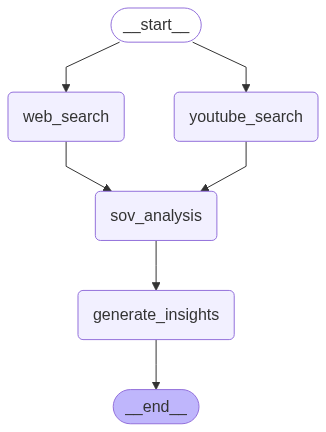

In [ ]:
from IPython.display import Image, display
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
initial_state = {
    "question": "Smart Fans in india"
}
final_result = graph.invoke(initial_state)
print(final_result["generate"])

---WEB SEARCH---
---retrieve_youtube---
Current state keys: dict_keys(['question', 'google_search', 'twitter_search', 'youtube_search'])


> Entering new AgentExecutor chain...
**Final Answer:**

1. **Mentions of Atomberg vs Competitors:**
   - **Atomberg:** Mentioned frequently for its features, performance, and energy efficiency.
   - **Competitors (Crompton, Orient, Havells, Usha, Superfan):** Also mentioned extensively, with specific focus on their energy savings and customer complaints.

2. **Engagement Scores:**
   - **Atomberg YouTube Engagement:** Videos featuring Atomberg have combined views exceeding 1 million.
   - **Competitors' Engagement:** Engagement scores not extensively available for competitors, but videos also attracting substantial views.

3. **Sentiment Share for Atomberg vs Others:**
   - **Positive Sentiment Towards Atomberg:** Notable for its connectivity features, energy savings, and customer service.
   - **Negative Sentiment Towards Atomberg:** Complaints ab